In [1]:
import pandas as pd
from glob import glob
import uclchem
import matplotlib.pyplot as plt
from seaborn import color_palette
from matplotlib.lines import Line2D

%matplotlib notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%ls ../src/uclchem_tools/output_files

Reference.h5                v3.1.0-dev-h3tomolhydrogen.h5
v3.1.0-dev-h3tohydrogen.h5  v3.1.0.h5


In [3]:
path = "../src/uclchem_tools/output_files/"
dirs = glob(path + "*.h5")
names = [dir_.split("/")[-1] for dir_ in dirs]
dfs = {name:{key:pd.read_hdf(dir_, key) for key in ["phase1", "phase2", "static"]} for name, dir_ in zip(names, dirs)}
dfs.keys()

dict_keys(['v3.1.0.h5', 'v3.1.0-dev-h3tomolhydrogen.h5', 'v3.1.0-dev-h3tohydrogen.h5', 'Reference.h5'])

In [4]:
dfs["v3.1.0-dev-h3tomolhydrogen.h5"].keys()

dict_keys(['phase1', 'phase2', 'static'])

In [10]:

def plot_species(ax, df, species, **plot_kwargs):
    """Plot the abundance of a list of species through time directly onto an axis.

    Args:
        ax (pyplot.axis): An axis object to plot on
        df (pd.DataFrame): A dataframe created by `read_output_file`
        species (str): A list of species names to be plotted. If species name starts with "$" instead of # or @, plots the sum of surface and bulk abundances

    Returns:
        pyplot.axis: Modified input axis is returned
    """

    color_palette(n_colors=len(species))
    for specIndx, specName in enumerate(species):
        linestyle = "solid"
        if specName[0] == "$" and specName.replace("$", "#") in list(df.columns):
            abundances = df[specName.replace("$", "#")]
            linestyle = "dashed"
            if specName.replace("$", "@") in df.columns:
                abundances = abundances + df[specName.replace("$", "@")]
        else:
            abundances = df[specName]
        ax.plot(
            df["Time"],
            abundances,
            label=specName,
            lw=2,
            linestyle=linestyle,
            **plot_kwargs,
        )
        ax.set(yscale="log")
    return ax


def plot_evolution(species_to_plot, runs_to_include, reference_run=None, verbose=False):
    i = 0
    fig, axes = plt.subplots(len(runs_to_include), 3, figsize=(24, 15), tight_layout=True)
#     axes = axes.flatten()
    model_names = {
        "phase1": "Collapsing Cloud",
        "phase2": "Hot Core",
        "static": "Static Cloud",
    }
    model_data = {}
    for idx_i, df_key in enumerate(runs_to_include):
        df = dfs[df_key]
        print(df.keys())
        for idx_j, model in enumerate(["phase1", "phase2", "static"]):
            axis = axes[idx_i, idx_j]

            for spec in species_to_plot:
                if spec not in list(df[model].columns):
                    if spec.startswith("$"):
                        if not spec.replace("$","#") in df[model]:
                            df[model][spec.replace("$","#")] = 1.0e-30
                        if not spec.replace("$","@") in df[model]:
                            df[model][spec.replace("$","@")] = 1.0e-30

                
#             for spec in ["#SI", "@SI", "#HE"]:
#                 if spec not in model_data[folder + model]:
#                     model_data[folder + model][spec] = 1.0e-30
# demonstrate checking element conservation
            if verbose:
                print(f"Testing element conservation for {df_key} in {model}: {uclchem.analysis.check_element_conservation(df[model])}")
            # plot species and save to test.png, alternatively send dens instead of time.

            axis = plot_species(
                axis, df[model], species_to_plot
            )
            if reference_run and df_key != reference_run:
                axis.set_prop_cycle(None)
                axis = plot_species(
                    axis, dfs[reference_run][model], species_to_plot, alpha=0.5
                )

            # plot species returns the axis so we can further edit
            axis.set(xscale="log", ylim=(1e-15, 1), xlim=(1, 6e6), yscale="log")
            
            if model == "phase1":
                axis.set(xlim=(1e3, 6e6))
            axis.set_title(model_names[model])
            i = i + 1
        if reference_run and df_key != reference_run:
            axis.legend([Line2D([0],[0]), Line2D([0],[0],alpha=0.5)], [df_key, reference_run], bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='lower left',)
    return fig, axes
    


<IPython.core.display.Javascript object>


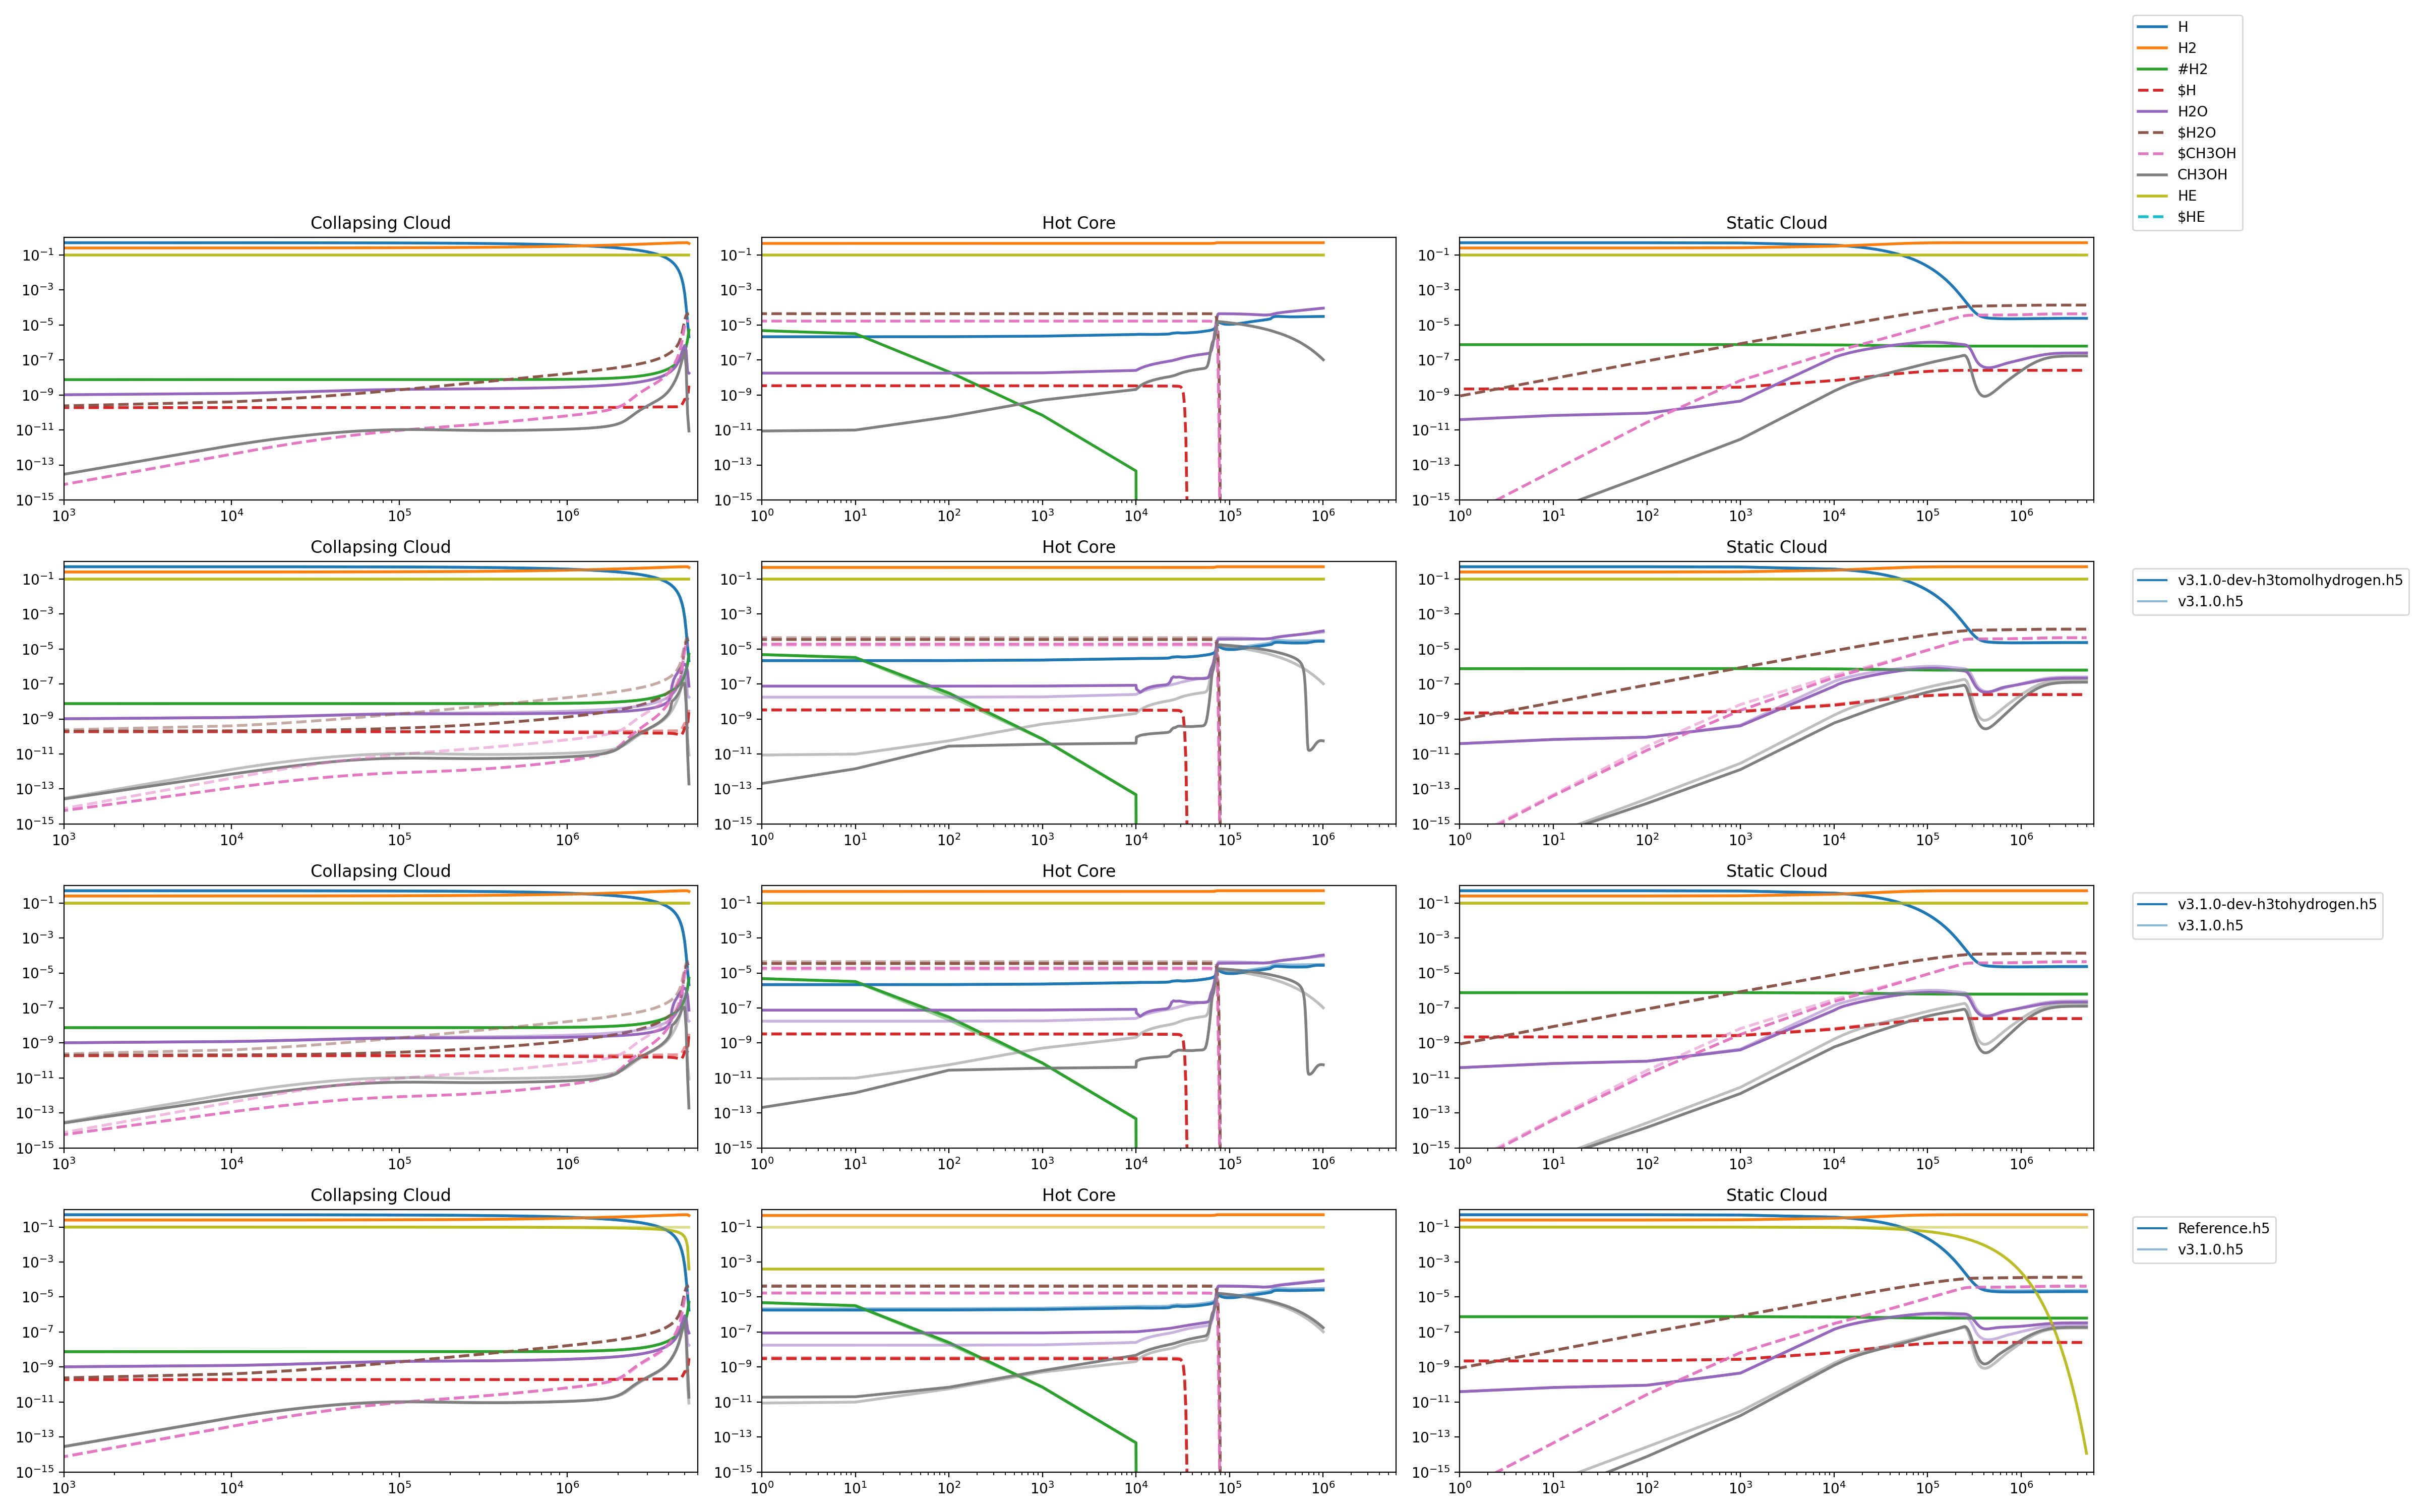

dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in phase2: {'H': '0.002%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in static: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.004%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase2: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in static: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tohydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0

(<Figure size 2400x1500 with 12 Axes>,
 array([[<AxesSubplot: title={'center': 'Collapsing Cloud'}>,
         <AxesSubplot: title={'center': 'Hot Core'}>,
         <AxesSubplot: title={'center': 'Static Cloud'}>],
        [<AxesSubplot: title={'center': 'Collapsing Cloud'}>,
         <AxesSubplot: title={'center': 'Hot Core'}>,
         <AxesSubplot: title={'center': 'Static Cloud'}>],
        [<AxesSubplot: title={'center': 'Collapsing Cloud'}>,
         <AxesSubplot: title={'center': 'Hot Core'}>,
         <AxesSubplot: title={'center': 'Static Cloud'}>],
        [<AxesSubplot: title={'center': 'Collapsing Cloud'}>,
         <AxesSubplot: title={'center': 'Hot Core'}>,
         <AxesSubplot: title={'center': 'Static Cloud'}>]], dtype=object))

In [11]:
speciesNames = [
    "H",
    "H2",
    "#H2",
    "$H",
    "H2O",
    "$H2O",
    # "CO",
    # "$CO",
    "$CH3OH",
    "CH3OH",
     "HE",
     "$HE",
]
plot_evolution(speciesNames, list(dfs.keys()), list(dfs.keys())[0], verbose=True)

<IPython.core.display.Javascript object>


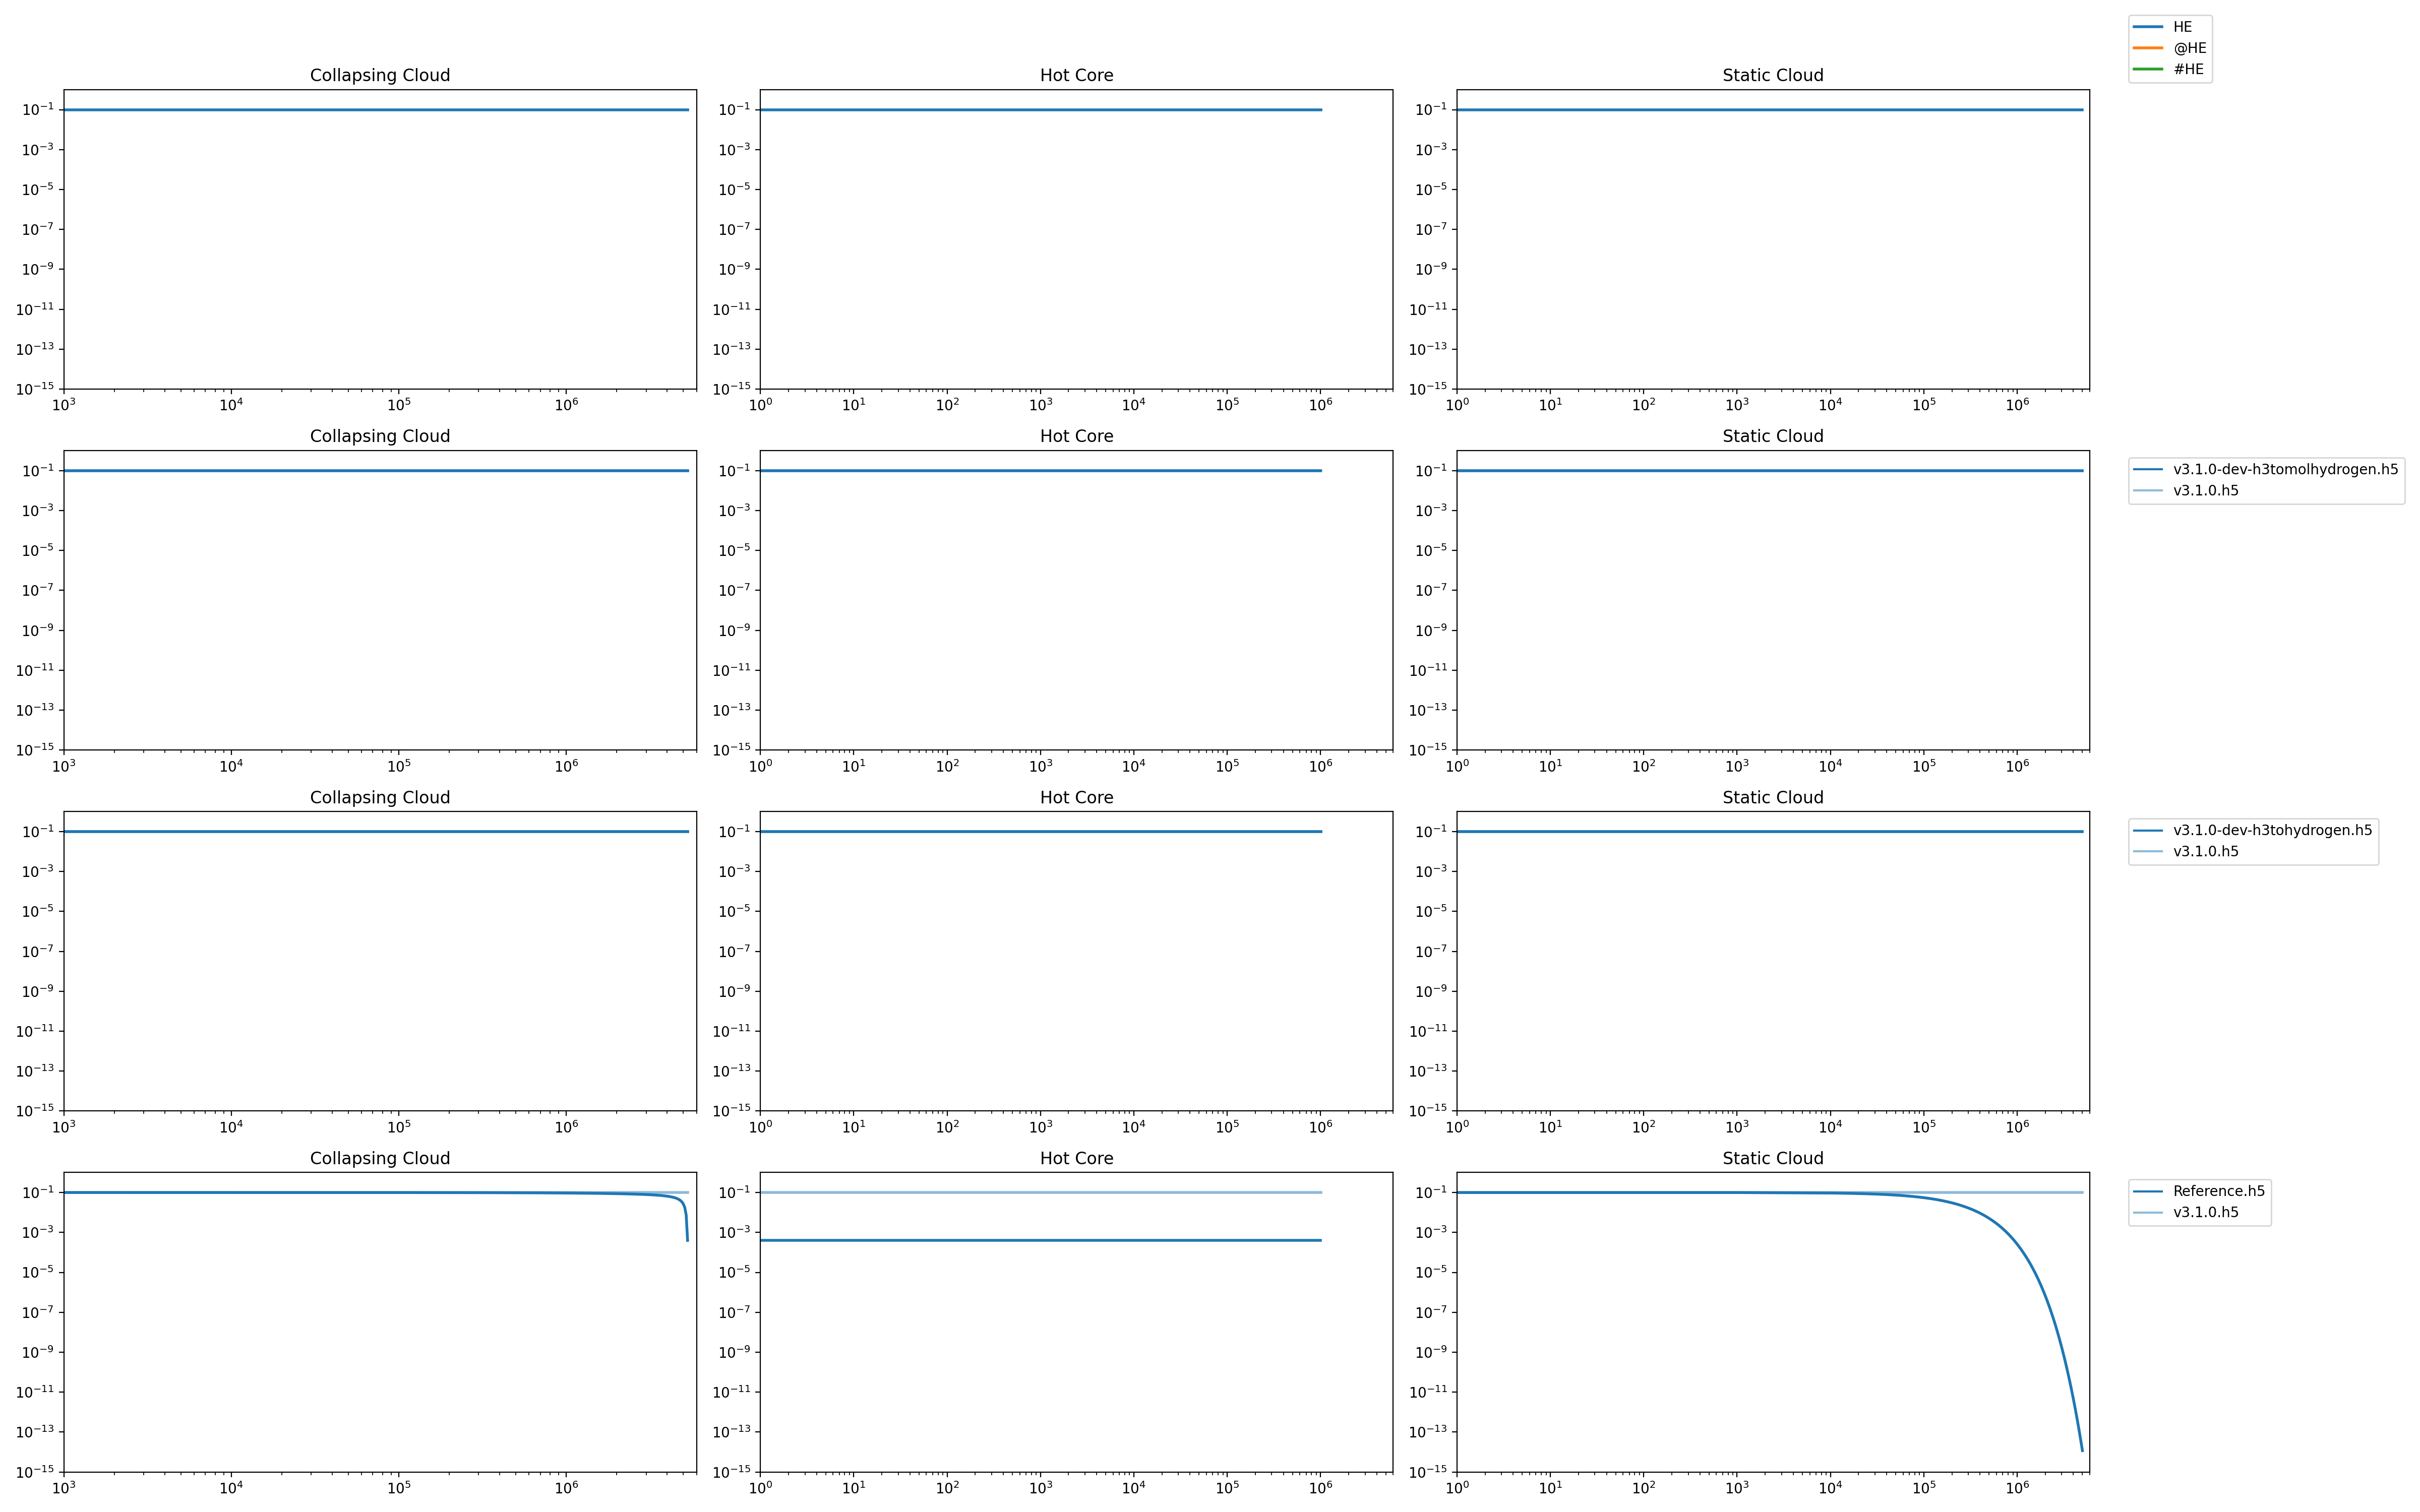

dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in phase2: {'H': '0.002%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in static: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.004%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase2: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in static: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tohydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0

In [7]:
speciesNames = [
    "HE",
    "@HE",
    "#HE",
]
plot_evolution(speciesNames, list(dfs.keys()), list(dfs.keys())[0], verbose=True)

<IPython.core.display.Javascript object>


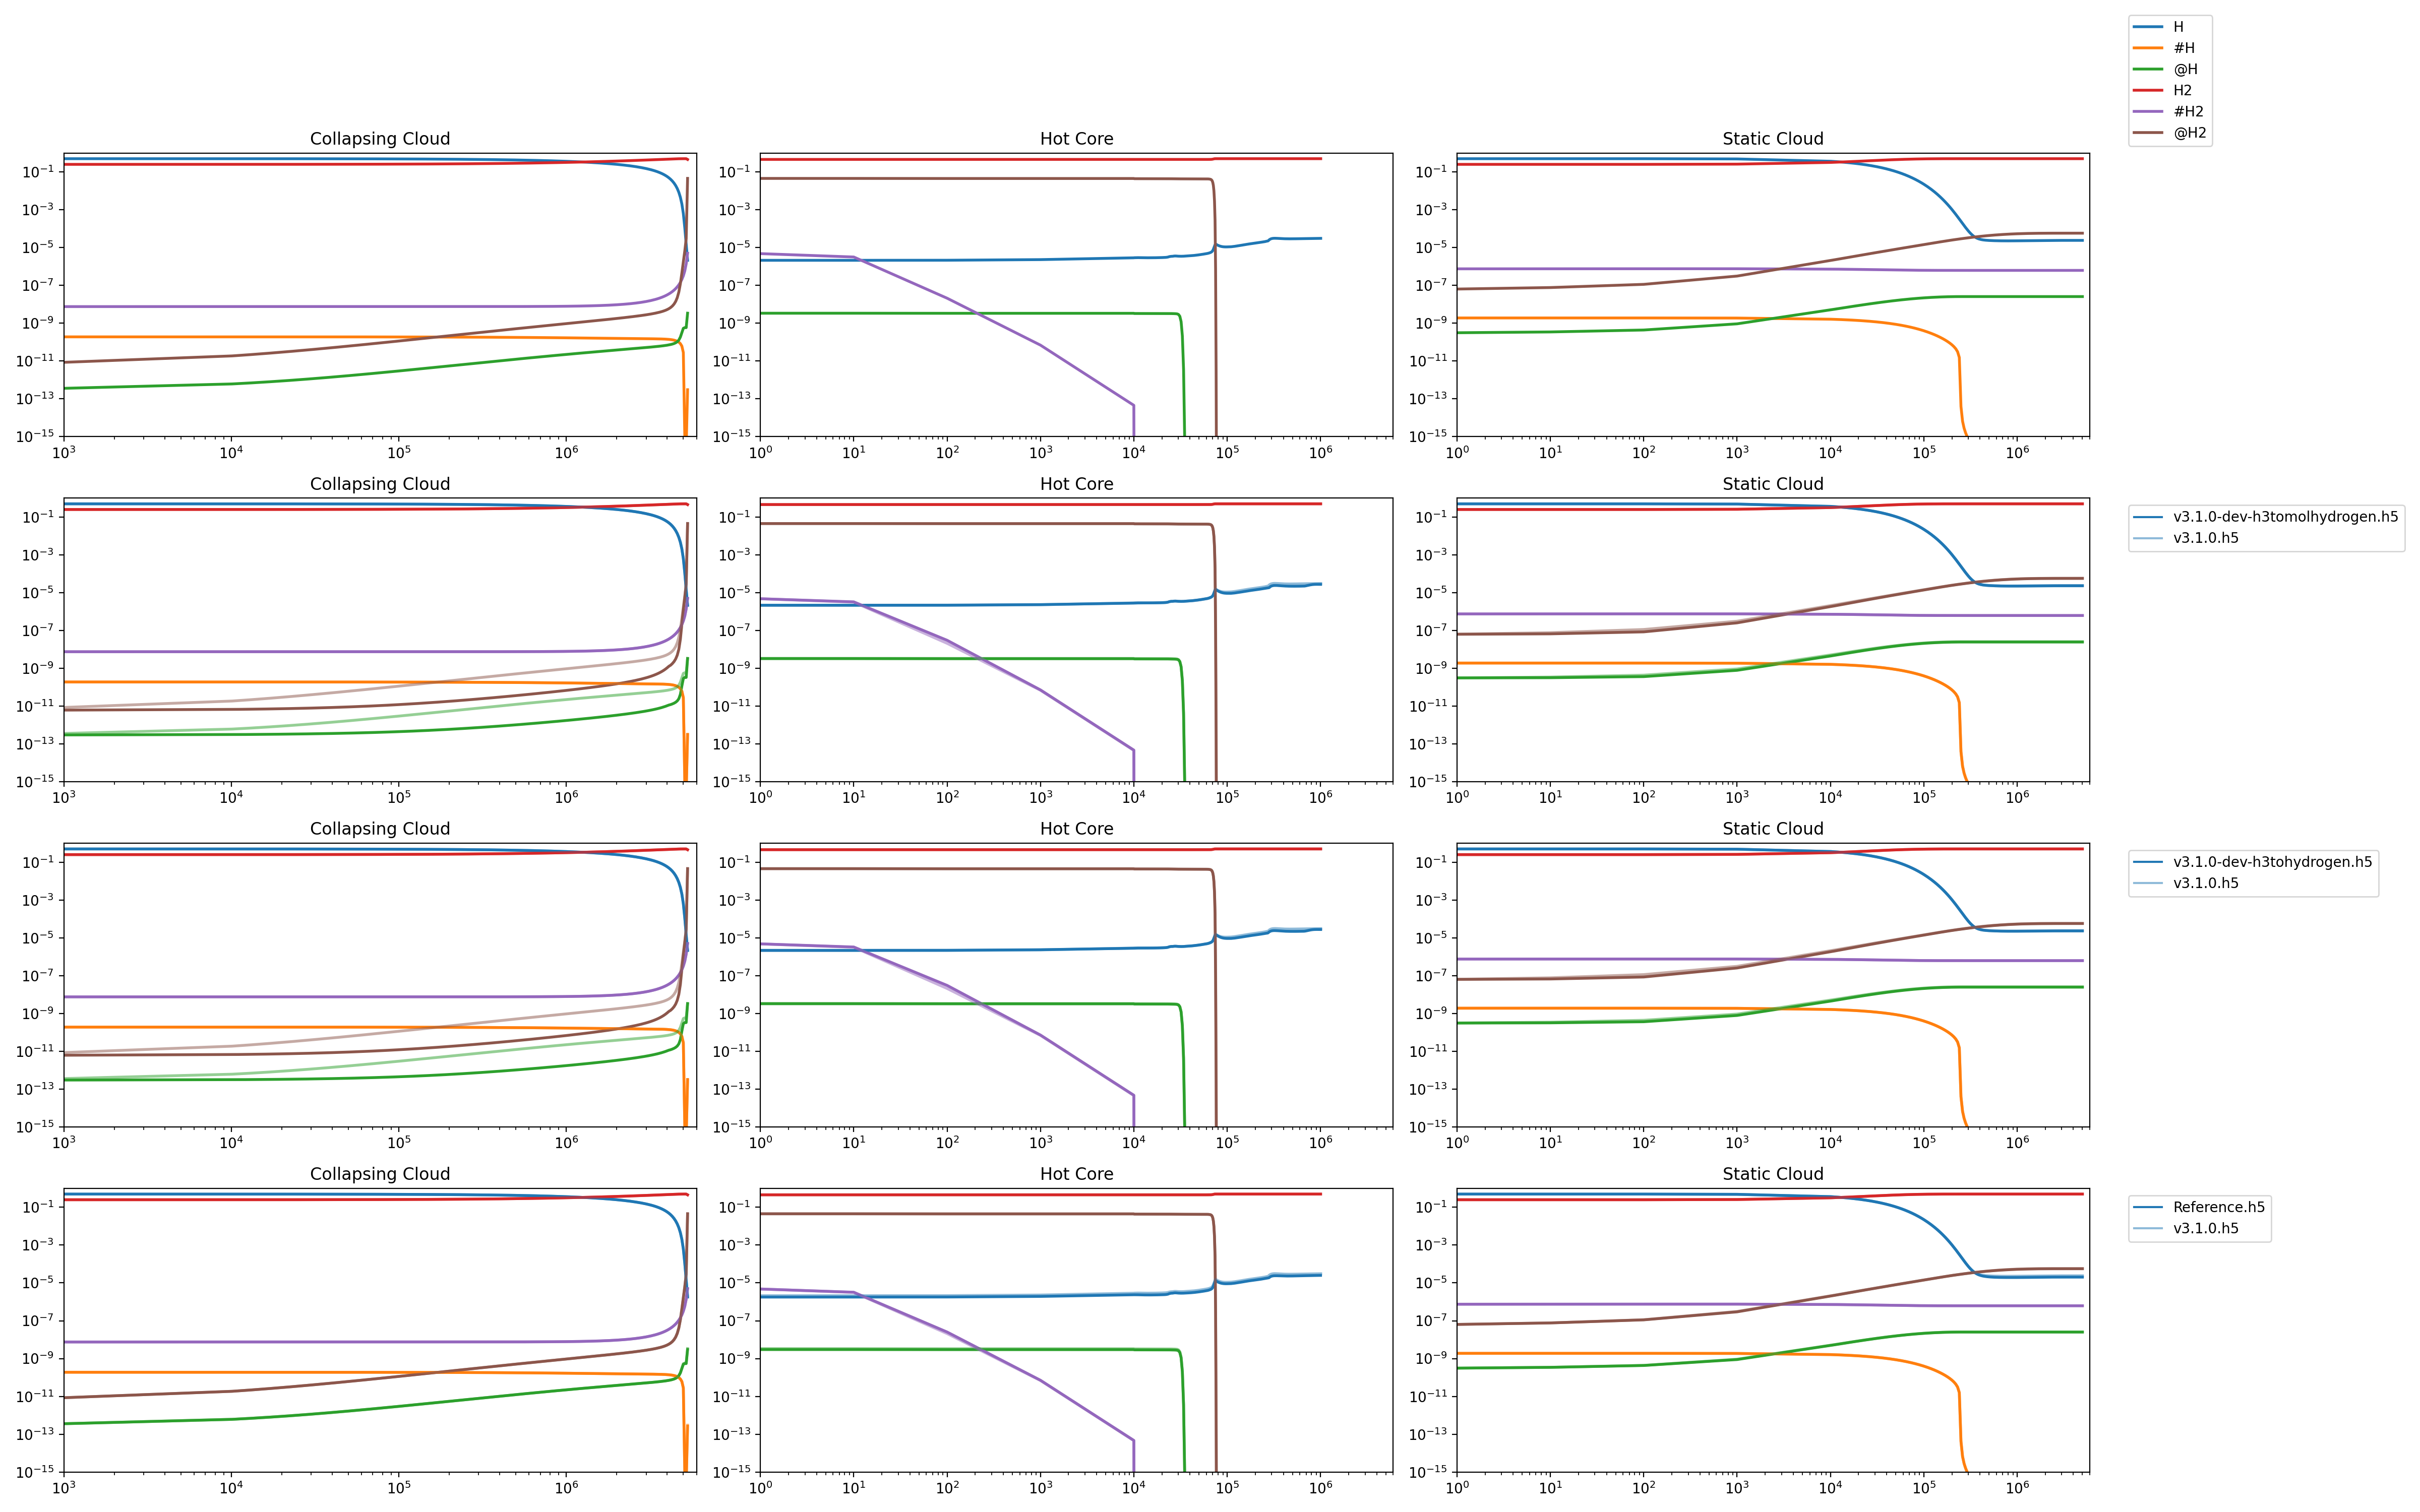

dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in phase2: {'H': '0.002%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in static: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.004%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase2: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in static: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tohydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0

In [8]:
speciesNames = [
    "H",
    "#H",
    "@H",
    "H2",
    "#H2",
    "@H2",
]
plot_evolution(speciesNames, list(dfs.keys()), list(dfs.keys())[0], verbose=True)

<IPython.core.display.Javascript object>


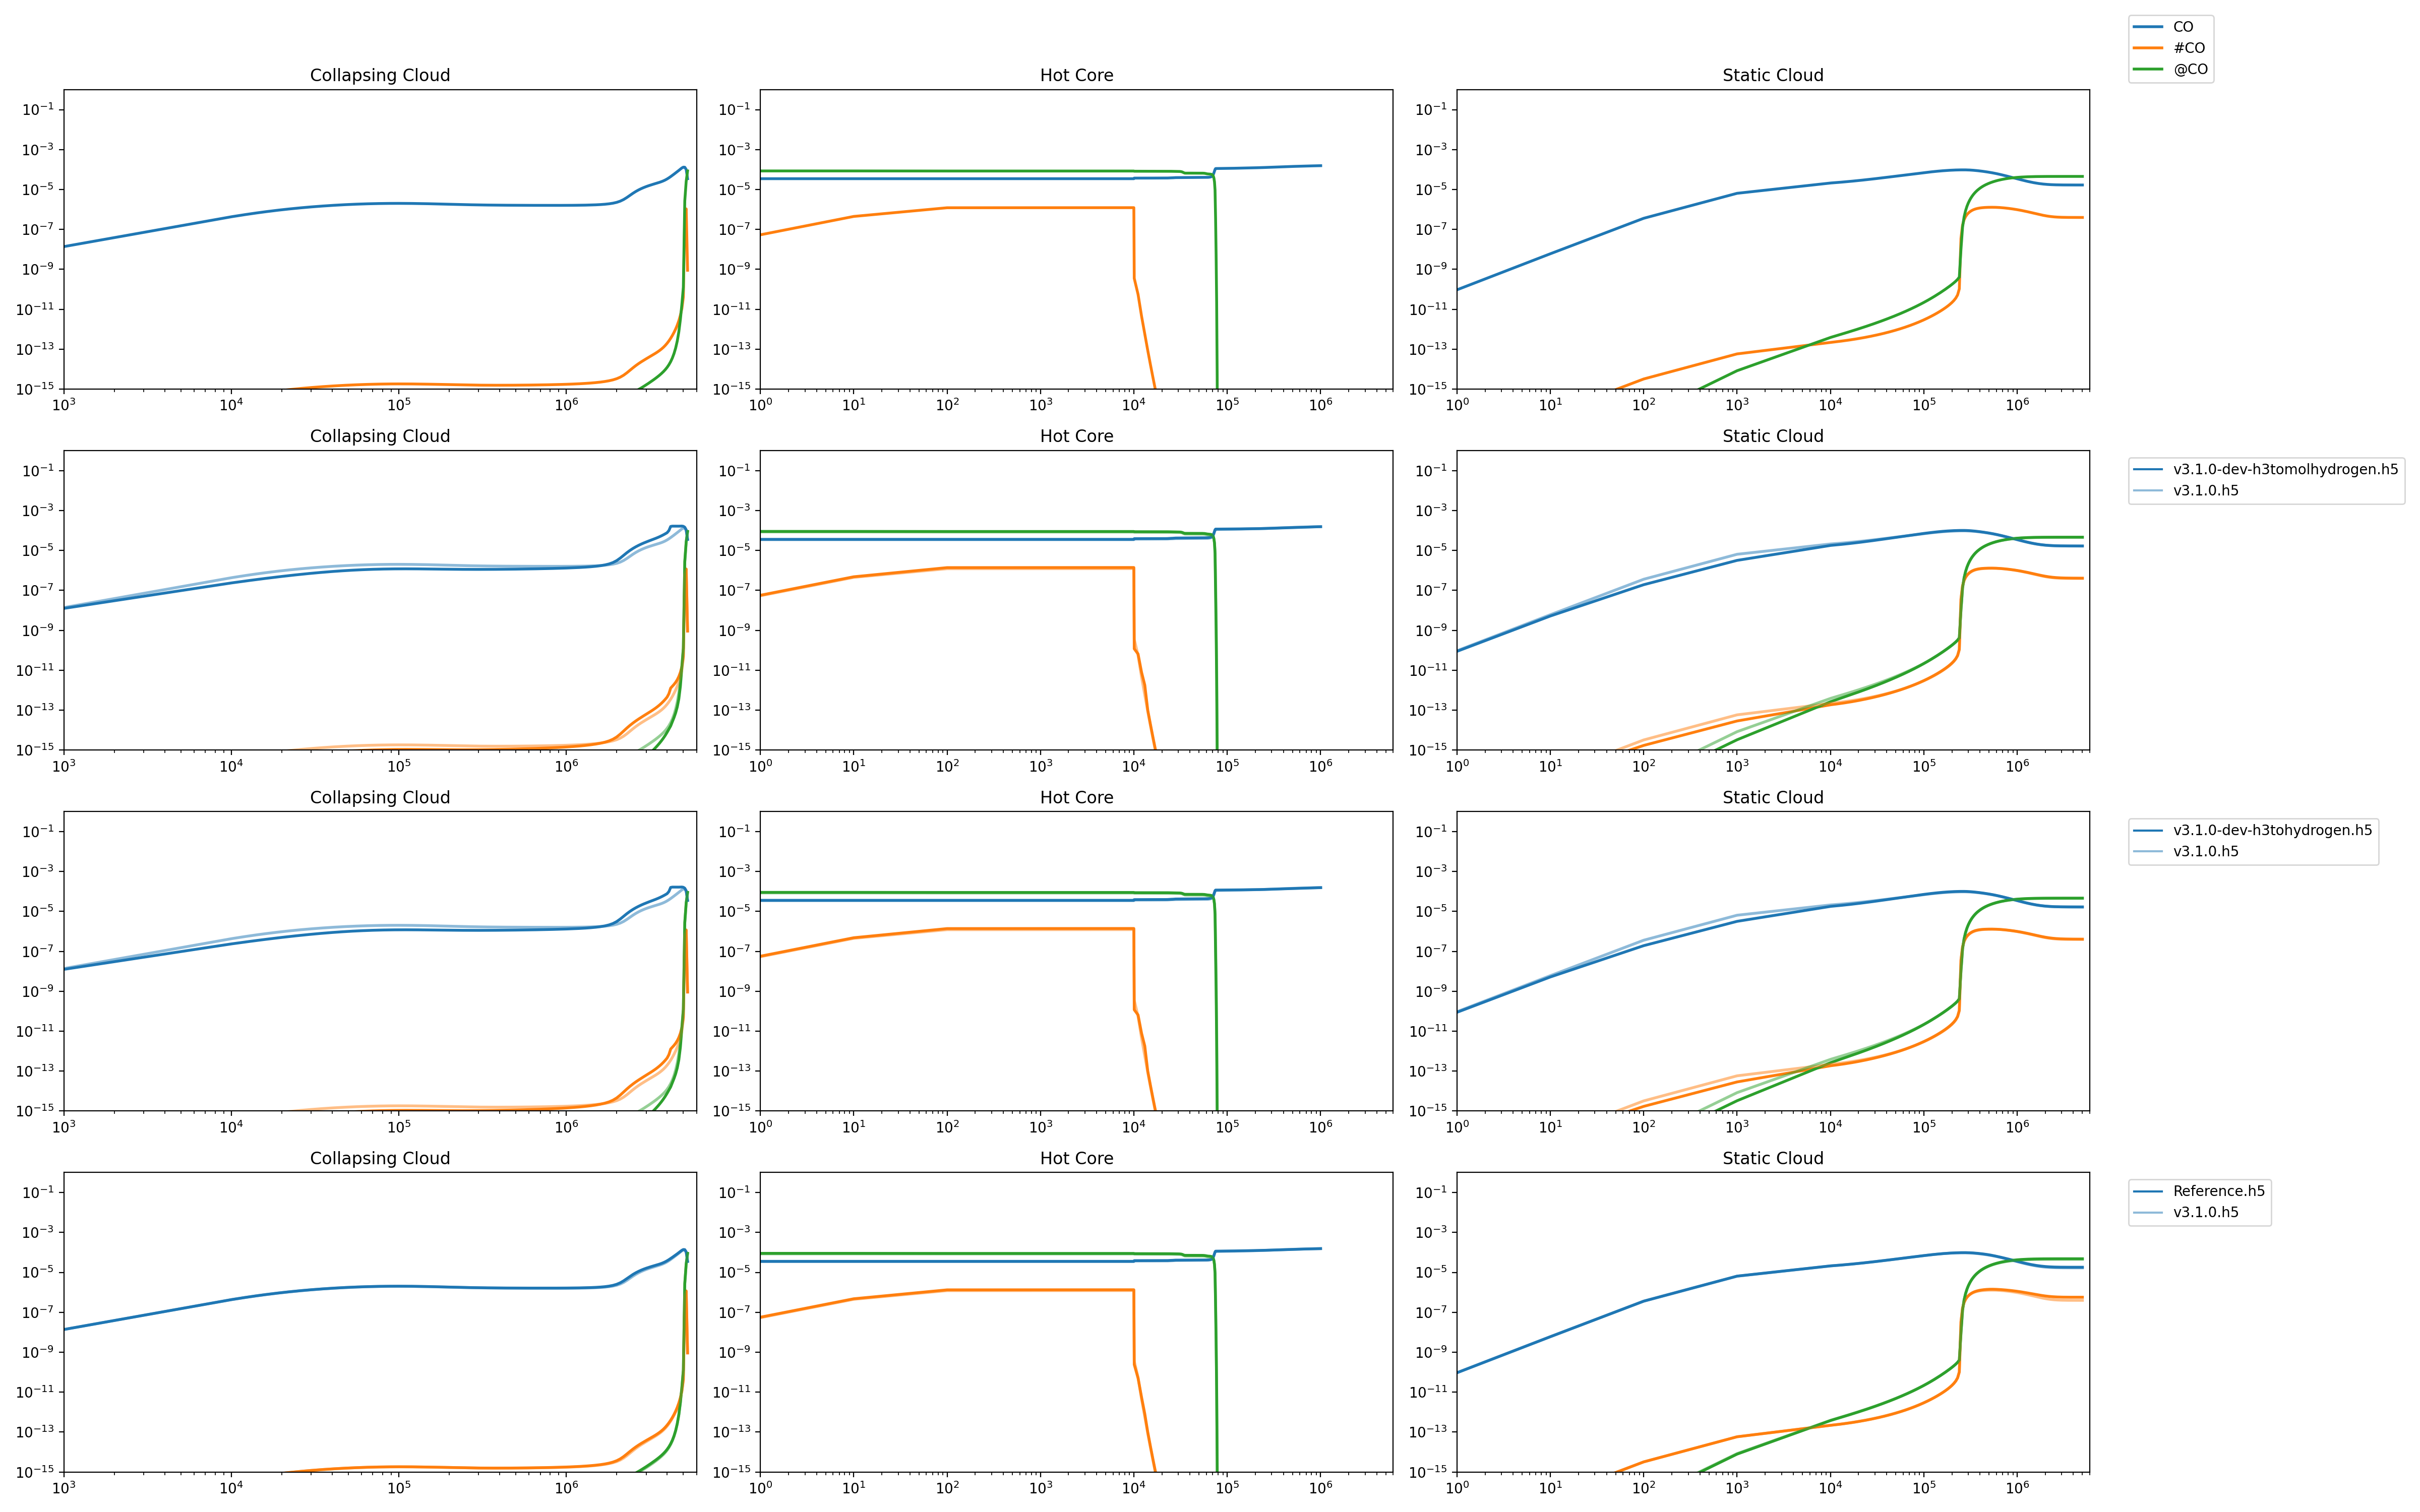

dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in phase2: {'H': '0.002%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0.h5 in static: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.004%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in phase2: {'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Testing element conservation for v3.1.0-dev-h3tomolhydrogen.h5 in static: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
dict_keys(['phase1', 'phase2', 'static'])
Testing element conservation for v3.1.0-dev-h3tohydrogen.h5 in phase1: {'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0

In [9]:
speciesNames = [
    "CO",
    "#CO",
    "@CO"
]
plot_evolution(speciesNames, list(dfs.keys()), list(dfs.keys())[0], verbose=True)